In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
import pandas as pd

import keras
from keras.models import Sequential
from keras.optimizers import Adam, schedules
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Input,GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
keras.utils.set_random_seed(42)

from keras import backend as K
import random
print(tf.__version__)

2024-05-27 07:35:28.399320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 07:35:28.399418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 07:35:28.570401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [2]:
train_path = '/kaggle/input/introanimal/raw-img'
test_path ='/kaggle/input/introanimal/test'
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3

NUMBER_CATEGORIES = os.listdir(train_path)

In [3]:
print(os.listdir(train_path))

['spider', 'horse', 'butterfly', 'dog', 'chicken', 'elephant', 'sheep', 'cow', 'squirrel', 'cat']


In [28]:
classes = {
    'spider' : 0,
    'horse': 1,
    'butterfly': 2,
    'dog':3,
    'chicken' : 4,
    'elephant':5,
    'sheep': 6,
    'cow' : 7,
    'squirrel': 8,
    'cat': 9
}

In [5]:
def load_data(paths,max_images_per_class, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    images = []
    labels = []
    folders = os.listdir(paths)
    for name in folders:
        class_path = os.path.join(paths, name)
        img_names = os.listdir(class_path)
        random.shuffle(img_names)  # Shuffle images to ensure randomness
        img_names = img_names[:max_images_per_class]  # Limit to max_images_per_class

        for img_name in img_names:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
                images.append(img)
                labels.append(classes[name])
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels


images_train , labels_train = load_data(train_path,max_images_per_class=750)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [6]:
print("Type of images: ",type(images_train))
print("Type of label: ", type(labels_train))

print("X_train shpae: ",images_train.shape)
print("X_train shpae: ",labels_train.shape)

Type of images:  <class 'numpy.ndarray'>
Type of label:  <class 'numpy.ndarray'>
X_train shpae:  (7500, 224, 224, 3)
X_train shpae:  (7500,)


In [7]:
def show_imgs(imgs, size, n):
    plt.figure(figsize=size)
    for i, img in enumerate(imgs):
        plt.subplot(n, n, i + 1)
        plt.imshow(img)
        plt.grid(visible=False)
        plt.xlabel(
            "{}x{}".format(img.shape[0], img.shape[1]), fontsize=30
        ) 

In [8]:
import sklearn.model_selection


# X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(
#    images_train,labels_train,test_size= 0.3, random_state= 42, shuffle= True
 #   )

#X_train = X_train/255
#X_val = X_val/255

# Assuming images_train and labels_train are your datasets
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(
    images_train, labels_train, test_size=0.15, random_state=42, shuffle=True
)

# Normalize the images and convert to float32 to save memory
X_train = (X_train / 255.0)
X_val = (X_val / 255.0)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", Y_train.shape)
print("y_valid.shape", Y_val.shape)


X_train.shape (6375, 224, 224, 3)
X_valid.shape (1125, 224, 224, 3)
y_train.shape (6375,)
y_valid.shape (1125,)


In [9]:
Y_train = keras.utils.to_categorical(Y_train)
Y_val = keras.utils.to_categorical(Y_val)
print(Y_train.shape)
print(Y_val.shape)

(6375, 10)
(1125, 10)


In [10]:
epochs = 30
batch_size = 32
train_size = len(Y_train)

print(train_size)

6375


In [11]:
data_gen = ImageDataGenerator(
    rotation_range = 30,
    zoom_range = 0.10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.15,
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode = 'nearest'
)

In [32]:
print(os.listdir(test_path))

['spider', 'horse', 'butterfly', 'dog', 'chicken', 'elephant', 'sheep', 'cow', 'squirrel', 'cat']


In [12]:
X_test, Y_test = load_data(test_path,max_images_per_class = 300 )
X_test = X_test/255

print(X_test.shape)
print(Y_test.shape)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


(2532, 224, 224, 3)
(2532,)


In [13]:
def adam_with_decay_lr(initial_learning_rate, final_learning_rate):
    learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1/ epochs)
    steps_per_epoch = int(train_size / batch_size)
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate= initial_learning_rate,
        decay_steps= steps_per_epoch,
        decay_rate = learning_rate_decay_factor,
        staircase= True,
    )
    opt = Adam(learning_rate=lr_schedule)
    return opt

In [14]:
def compile_and_fit(model):
    model.compile(loss = "categorical_crossentropy", optimizer = adam_with_decay_lr(0.001,0.000001), metrics = ["accuracy"]) #optimizer = adam_with_decay_lr(0.001,0.000001)
    history = model.fit(
        data_gen.flow(X_train, Y_train, batch_size = batch_size),
        epochs = epochs,
        validation_data = (X_val, Y_val),
    )
    K.clear_session()
    return history

In [15]:
def plot_history(h, title):
    pd.DataFrame(h.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title(title)
    plt.show()

In [16]:
def accuracy(model):
    pred = np.argmax(model.predict(X_test), axis= 1)
    model_accuracy = accuracy_score(Y_test, pred)
    return model_accuracy*100

In [17]:
img_size = 224
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

# Freezing layers except the last two
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Adding layers to the model
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = BatchNormalization(axis = -1)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding Dropout with a rate of 0.5
outputs = Dense(10, activation='softmax')(x)

# Creating the model
model = Model(inputs=base_model.inputs, outputs=outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,13

 Total params: 14,984,522 (57.16 MB)

 Trainable params: 2,628,618 (10.03 MB)

 Non-trainable params: 12,355,904 (47.13 MB)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/200 ━━━━━━━━━━━━━━━━━━━━ 2:05:48 38s/step - accuracy: 0.0938 - loss: 2.4722

I0000 00:00:1716795468.612873     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716795468.634248     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.5371 - loss: 1.4490

W0000 00:00:1716795560.682238     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 522ms/step - accuracy: 0.5376 - loss: 1.4474 - val_accuracy: 0.6773 - val_loss: 0.9175
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 87s 418ms/step - accuracy: 0.7585 - loss: 0.7143 - val_accuracy: 0.8000 - val_loss: 0.6025
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 86s 417ms/step - accuracy: 0.8328 - loss: 0.5145 - val_accuracy: 0.8027 - val_loss: 0.5782
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 143s 420ms/step - accuracy: 0.8636 - loss: 0.4102 - val_accuracy: 0.8613 - val_loss: 0.4672
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 86s 417ms/step - accuracy: 0.8807 - loss: 0.3688 - val_accuracy: 0.8631 - val_loss: 0.4547
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 87s 419ms/step - accuracy: 0.8923 - loss: 0.3095 - val_accuracy: 0.8569 - val_loss: 0.4710
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 85s 412ms/step - accuracy: 0.9086 - loss: 0.2803 - val_accuracy: 0.8613 - val_loss: 0.4367
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 86s 413ms/step - accuracy: 0.9266 - loss: 0.2162 - v

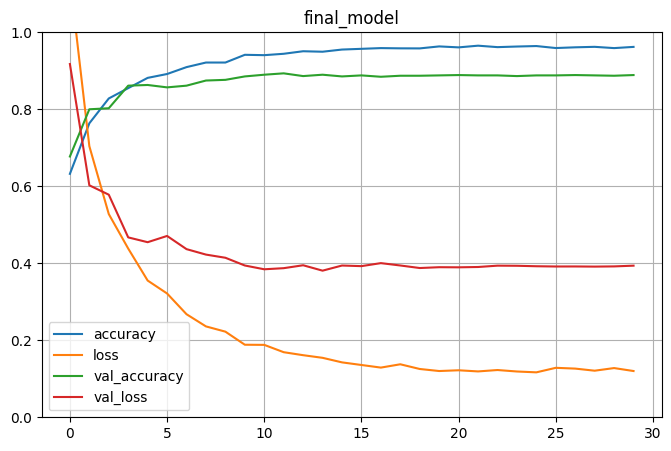

In [19]:
K.clear_session()
final_history = compile_and_fit(model)
plot_history(final_history, "final_model")

In [20]:
print(f"Accuracy",{accuracy(model)})

 2/80 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step 

W0000 00:00:1716798191.083472     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 205ms/step
Accuracy {89.92890995260665}


In [21]:
from sklearn.metrics import classification_report

prediction = np.argmax(model.predict(X_test), axis=1)
print(classification_report(Y_test, prediction))


80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       300
           1       0.92      0.90      0.91       300
           2       0.93      0.98      0.95       300
           3       0.92      0.82      0.87       300
           4       0.90      0.94      0.92       300
           5       0.82      0.93      0.87       156
           6       0.84      0.84      0.84       216
           7       0.87      0.91      0.89       240
           8       0.94      0.84      0.89       300
           9       0.84      0.95      0.89       120

    accuracy                           0.90      2532
   macro avg       0.89      0.90      0.90      2532
weighted avg       0.90      0.90      0.90      2532



In [22]:
model.save('/kaggle/working/84percentsmodel.keras')

 2/80 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step

W0000 00:00:1716799523.833285     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step


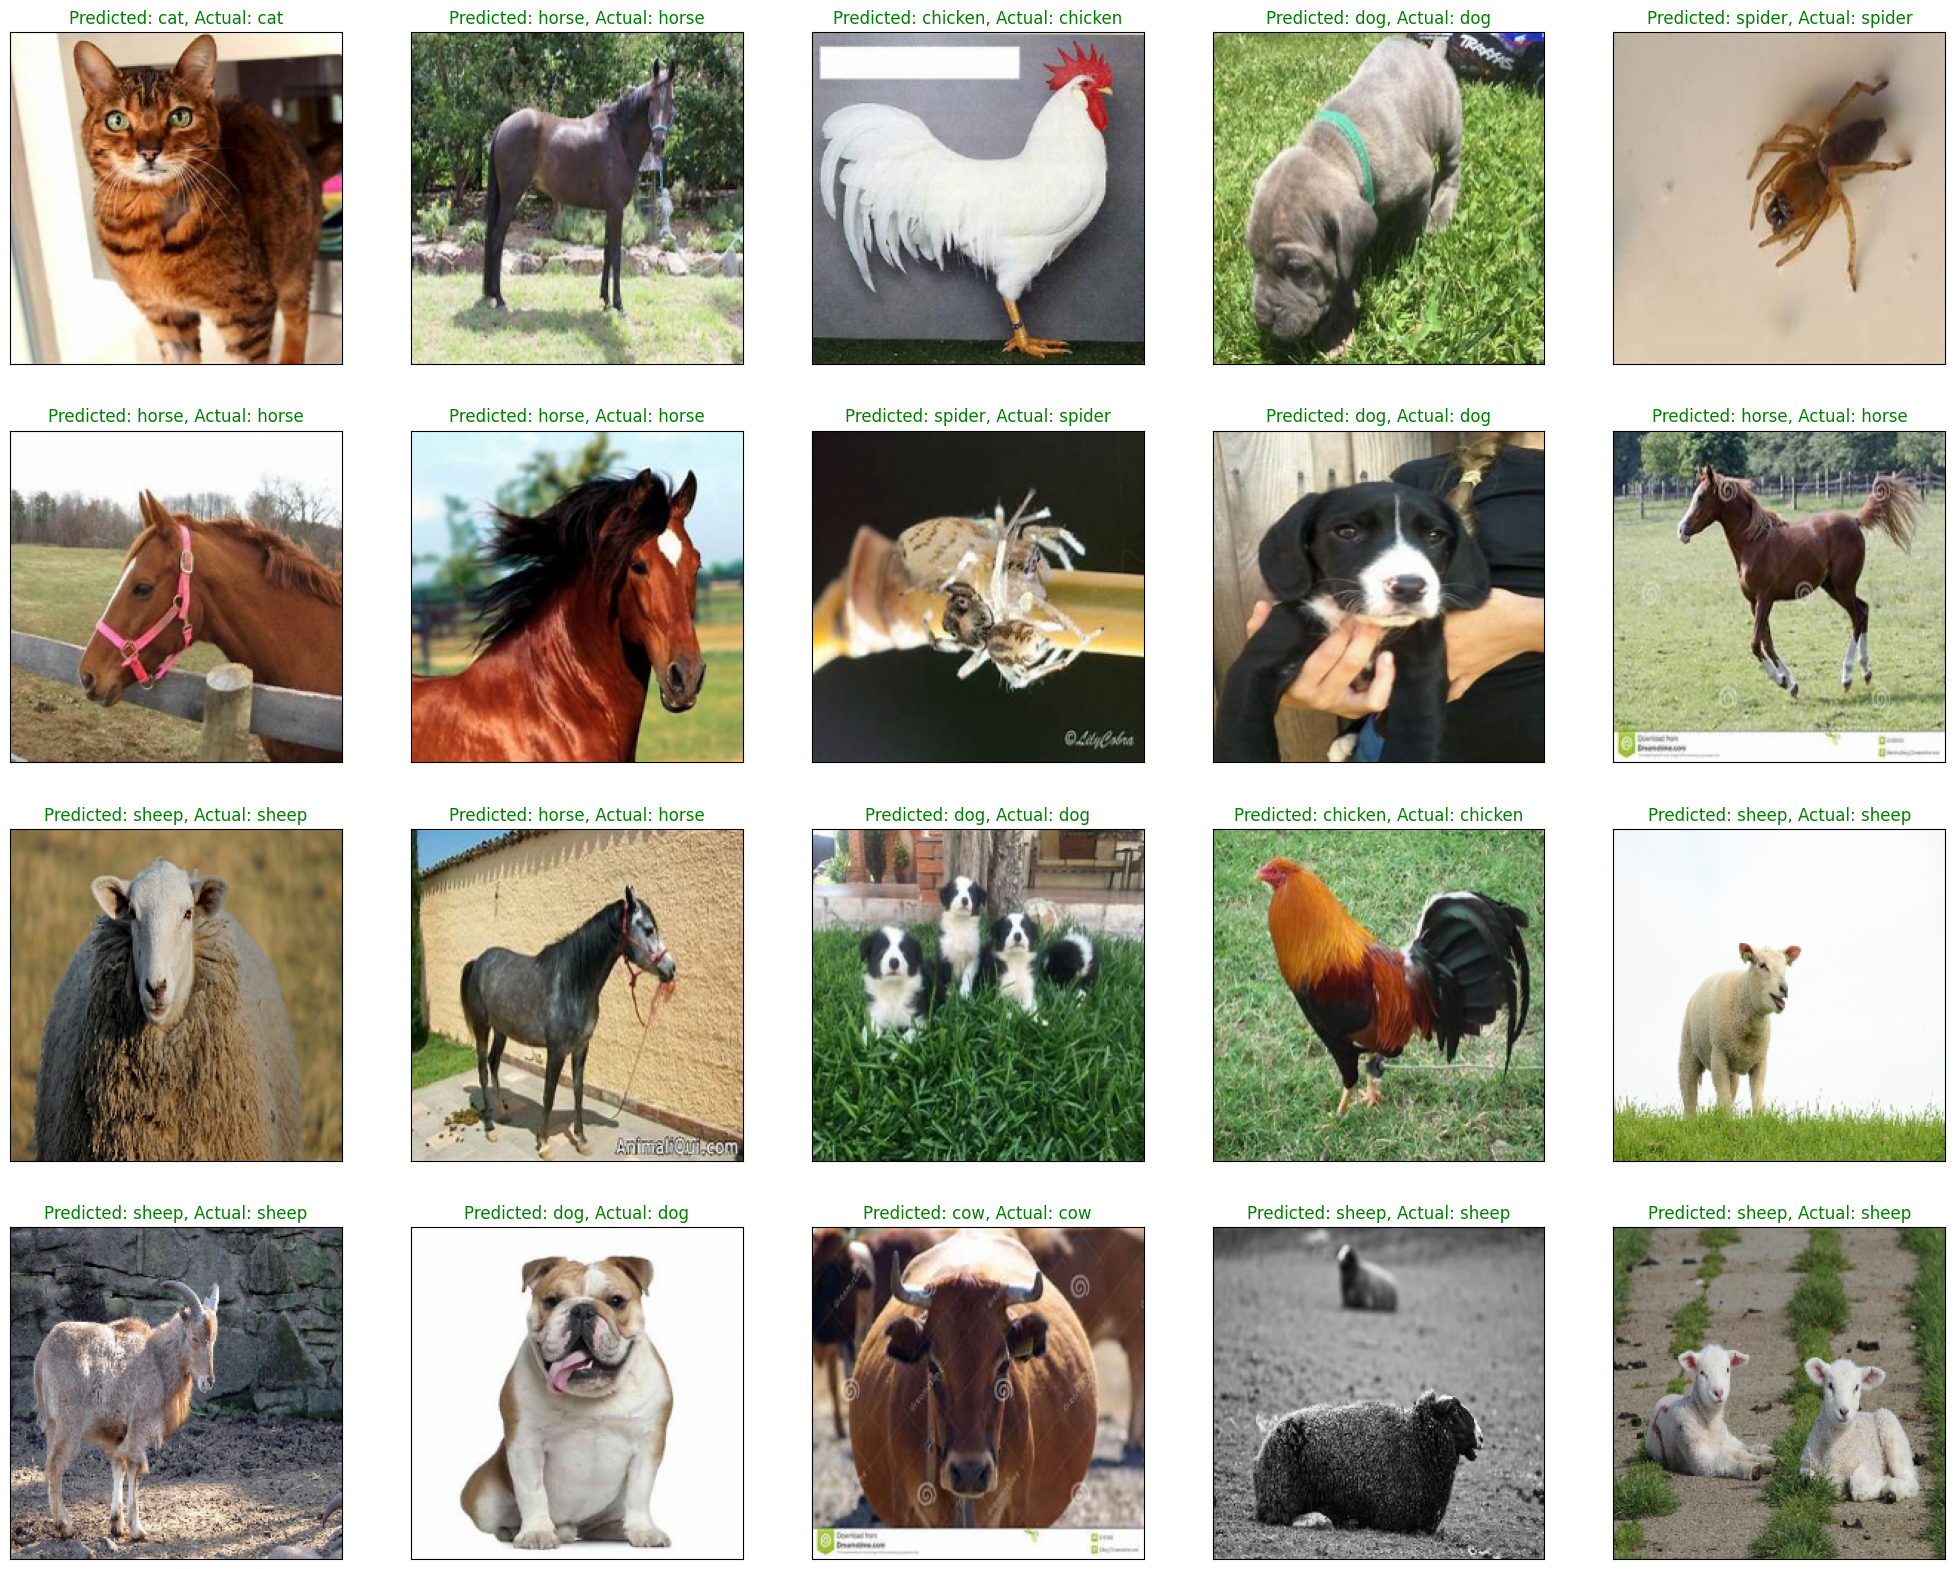

In [38]:
from tensorflow.keras.models import load_model
# Invert the classes dictionary to map indices to class names
inverted_classes = {v: k for k, v in classes.items()}

def plot_correct_predictions(model, X_test, Y_test, class_labels, n=20):
    
    plt.figure(figsize=(25, 25))

    # Get predictions
    predictions = np.argmax(model.predict(X_test), axis=1)
    true_labels = Y_test  # Use Y_test directly since it's not one-hot encoded
    correct_indices = [i for i in range(len(predictions)) if predictions[i] == true_labels[i]]
    random_indices = np.random.choice(correct_indices, min(n, len(correct_indices)), replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(5, 5, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        pred = predictions[idx]
        actual = true_labels[idx]
        plt.title(f"Predicted: {class_labels[pred]}, Actual: {class_labels[actual]}", color="g")
        plt.imshow(X_test[idx])

    plt.show()

# Plot the correct predictions
model = load_model("/kaggle/working/84percentsmodel.keras")
plot_correct_predictions(model, X_test, Y_test, inverted_classes)